# Parameter estimation example: Gaussian noise and averages I

Adapted from Sivia: *Data Analysis: A Bayesian Tutorial*

Here we'll take a look at a simple parameter-estimation problem. We will discuss a Bayesian approach to this problem and show how it reduces to standard frequentist estimators for a particular choice of prior. This problem is an extended version of Example 2 in Ch 2.3 of the book by Sivia. 

This notebook was adapted from a broad introduction to Bayesian statistics put together by Christian Forssen for the 2019 TALENT school on ["Learning from Data"](https://nucleartalent.github.io/Bayes2019/).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Not really needed, but nicer plots
import seaborn as sns
sns.set()      
sns.set_context("talk")

In [2]:
# Modules needed for example: emcee is for MCMCsampling, corner for plotting
from scipy import stats

Let us consider the problem of estimating the mean and the variance of a normal distribution that is associated with a collection of random variables. The normal distribution
$$
p(x|\mu,\sigma) = \frac{1}{\sqrt{2\pi}\sigma} \exp \left(-\frac{(x-\mu)^2}{2\sigma^2} \right),
$$
is often used as a theoretical model to describe the noise associated with experimental data.

*Why is a normal (Gaussian) distribution so often a good statistical model?* 


Let us assume that we have a series of $M$ measurements $D \equiv \{ x_k \} = (x_1, \ldots, x_M)$, that are samples from a normal $\mathcal{N}(\mu, \sigma^2)$ population, from which we would like to learn the approximate values of the parameters $\mu$ and $\sigma$. The standard frequentist approach to this problem is the maximum likelihood method. The Bayesian approach is to compute the posterior distribution for the model parameters $\mu$ and $\sigma$.

Here we'll use Python to generate some toy data to demonstrate the two approaches to the problem. 

In [3]:
# Generating some data
np.random.seed(10)  # for repeatability

mu_true = 10   # true peak position 
sigma_true = 1 # true standard deviation 
M = 100 # number of measurements
D = stats.norm.rvs(mu_true, sigma_true, size=M)  # M measurements (samples)

**Side note:** try shift-tab-tab to get documentation!

*Look at the array `D`.  Are the number of entries in the "tails" what you would expect?*  

In [4]:
D

array([11.3315865 , 10.71527897,  8.45459971,  9.99161615, 10.62133597,
        9.27991444, 10.26551159, 10.10854853, 10.00429143,  9.82539979,
       10.43302619, 11.20303737,  9.03493433, 11.02827408, 10.22863013,
       10.44513761,  8.86339779, 10.13513688, 11.484537  ,  8.92019511,
        8.02227172,  8.2566277 , 10.26607016, 12.38496733, 11.12369125,
       11.67262221, 10.09914922, 11.39799638,  9.72875201, 10.61320418,
        9.73268281,  9.45069099, 10.1327083 ,  9.52385799, 11.30847308,
       10.19501328, 10.40020999,  9.66236766, 11.25647226,  9.2680305 ,
       10.66023155,  9.64912811,  9.06056664,  9.51066278,  9.19540886,
        9.78730236,  9.66085975, 10.31216994, 10.56515267,  9.85257974,
        9.97409466, 10.2890942 ,  9.46012093, 10.70816002, 10.84222474,
       10.2035808 , 12.39470366, 10.91745894,  9.88772753,  9.63781955,
        9.76781774,  9.4982711 , 11.12878515,  9.30218997,  9.91887782,
        9.47070392, 11.04618286,  8.58144397,  9.63750082,  9.87

*Hint: Roughly how many entries do you expect to find two sigma away from the mean?*

Let's verify your answer with visualizations!

First, let's make two simple visualizations of the "measured" data: a scatter plot and a histogram

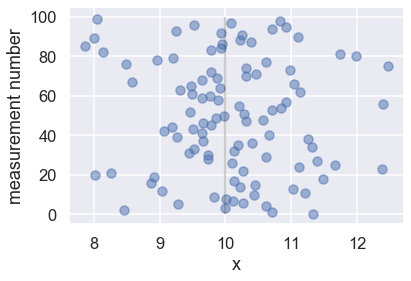

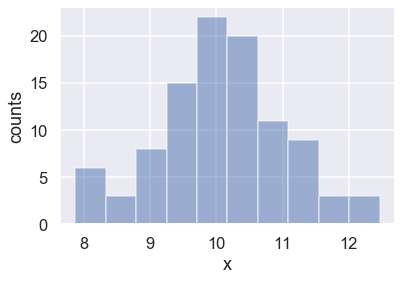

In [5]:
fig1, ax1 = plt.subplots()
ax1.scatter(D, np.arange(M), alpha=0.5)
ax1.vlines([mu_true], 0, M, alpha=0.2)
ax1.set_xlabel("x"); ax1.set_ylabel("measurement number");

fig2, ax2 = plt.subplots()
ax2.hist(D,alpha   =0.5)
#ax1.vlines([mu_true], 0, M, alpha=0.2)
ax2.set_xlabel("x"); ax2.set_ylabel("counts");


`Matplotlib` alternative: one figure with two subplots using an array of axes.

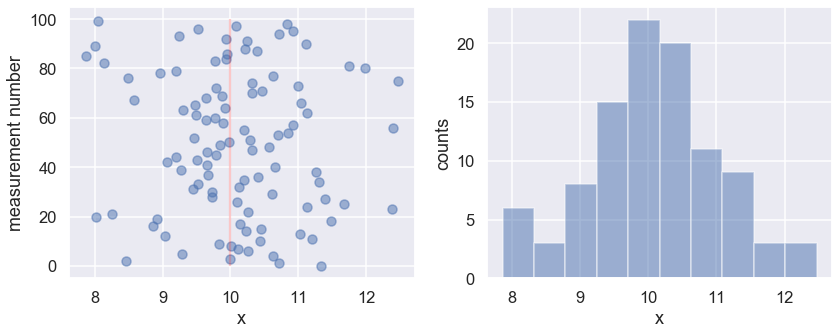

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
# An alternative keeping the same axis names as before would be:
#  fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

axes[0].scatter(D, np.arange(M), alpha=0.5)
axes[0].vlines([mu_true], 0, M, color='red', alpha=0.2)
axes[0].set_xlabel("x"); axes[0].set_ylabel("measurement number");

axes[1].hist(D,alpha=0.5)
axes[1].set_xlabel("x"); axes[1].set_ylabel("counts");

fig.tight_layout()

*What can you conclude about the tails?*

*Change np.random.seed(1) to a different number so that a different set of random numbers is generated.*

### Bayesian approach to Gaussian parameter estimation
The Bayesian approach begins and ends with probabilities (pdfs).  It recognizes that what we fundamentally want to compute is our knowledge of the parameters in question, i.e. in this case,

$$ p(\mu,\sigma~|~D, I) $$

Note that this formulation of the problem is *fundamentally contrary* to the frequentist philosophy, which says that *probabilities have no meaning for model parameters* like $\mu,\sigma$. Nevertheless, within the Bayesian philosophy this is perfectly acceptable. 

To compute this result, Bayesians next apply [Bayes' Theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem), here with the hypothesis being the Gaussian model expressed in terms of the model parameters

$$ p(\mu,\sigma~|~D, I) = \frac{p(D~|~\mu,\sigma, I)~p(\mu,\sigma~|~I)}{p(D~|~I)} $$

Though Bayes' theorem is where Bayesians get their name, it is not this law itself that is controversial, but the Bayesian *interpretation of probability* implied by the term $p(\mu,\sigma~|~D, I)$.

Let's take a look at each of the terms in this expression:

- $p(\mu,\sigma~|~D, I)$: The **posterior**, or the probability of the model parameters given the data: this is the result we want to compute.
- $p(D~|~\mu,\sigma, I)$: The **likelihood**, which is proportional to the $\mathcal{L}(D~|~\mu,\sigma)$ in the frequentist approach, above.
- $p(\mu,\sigma~|~I)$: The **model prior**, which encodes what we knew about the model prior to the application of the data $D$.
- $p(D~|~I)$: The **data probability**, which in practice amounts to simply a normalization term.

If we set the prior $p(\mu,\sigma~|~I) \propto 1$ (a *flat prior*), we find

$$p(\mu,\sigma~|~D,I) \propto \mathcal{L}(D|\mu,\sigma)$$

and the Bayesian probability is maximized at precisely the same value as the frequentist result! So despite the philosophical differences, we see that (for this simple problem at least) the Bayesian and frequentist point estimates are equivalent.



We'll therefore start with the classical frequentist **maximum likelihood** approach. The probability of a single measurement $D_i$ having a value $x_i$ is given by 

$$ p(x_i~|~\mu, \sigma) = \frac{1}{\sqrt{2\pi \sigma^2}} \exp{\left[\frac{-(x_i - \mu)^2}{2 \sigma^2}\right]}, $$

where $\mu$, $\sigma$ are the *true* values for the model parameters.

We construct the **likelihood function** by computing the product of the probabilities for each data point:

$$\mathcal{L}(D~|~\mu, \sigma) = \prod_{i=1}^M p(x_i~|~\mu, \sigma)$$




Because the value of the likelihood can become very small, it is often more convenient to instead compute the log-likelihood. Furthermore, when we are looking for the maximum of the likelihood, we might just as well maximize the log-likelihood. Combining the previous two equations and computing the log, we have

$$\log\mathcal{L} = -\frac{1}{2} \sum_{i=1}^M \left[ \log(2\pi  \sigma^2) + \frac{(x_i - \mu)^2}{\sigma^2} \right]$$

What we'd like to do is find $\mu_0,\sigma_0$ such that the likelihood (or log likelihood) is maximized. For this simple problem, the maximization can be computed analytically (i.e. by setting $\left. \partial\log\mathcal{L}/\partial\mu \right|_{\mu_0,\sigma_0} = \left. \partial\log\mathcal{L}/\partial\sigma \right|_{\mu_0,\sigma_0} = 0$).  This results in the following *maximum-likelihood estimates* of the true parameters:

$$ 
\mu_0 = \frac{1}{M}\sum_{i=1}^M x_i \\
\sigma_0^2 = \frac{1}{M}\sum_{i=1}^M (x_i - \mu_0)^2
$$

In principle, we should also compute the second derivatives to make sure that this point represents a maximum rather than a minimum or a saddle point. However, in agreement with intuition, $\mu_0$ is simply the mean of the observed data. These results are fairly simple calculations; let's evaluate them for our toy dataset:

In [7]:
# Estimators: sample mean and (sqrt of) sample variance
# Sometimes the *unbiased* estimator for the sample variance is used 
# with (M-1) degrees of freedom...
mu_est = D.sum()/M
sigma_est = np.sqrt(((D-mu_est)**2).sum()/M)
print("""
      (mu,sigma)_true = {0:.2f}, {1:.2f}
      
      Sample estimators: 
      (mu,sigma)_0  = {2:.2f}, {3:.2f} (based on {4} measurements)
      """.format(mu_true, sigma_true, mu_est, sigma_est, M))


      (mu,sigma)_true = 10.00, 1.00
      
      Sample estimators: 
      (mu,sigma)_0  = 10.08, 0.97 (based on 100 measurements)
      


**Aside:** using `fstrings` by putting an `f` in front of the quotes.

In [8]:
# Estimators: sample mean and (sqrt of) sample variance
# Sometimes the *unbiased* estimator for the sample variance is used with 
# (M-1) degrees of freedom...
mu_est = D.sum()/M
sigma_est = np.sqrt(((D-mu_est)**2).sum()/M)
print(f"""
      (mu,sigma)_true = {mu_true:.2f}, {sigma_true:.2f}
      
      Sample estimators:
      (mu,sigma)_0 = {mu_est:.2f}, {sigma_est:.2f} (based on {M} measurements)
      """)


      (mu,sigma)_true = 10.00, 1.00
      
      Sample estimators:
      (mu,sigma)_0 = 10.08, 0.97 (based on 100 measurements)
      


### But what about the prior?
You'll noticed that we glossed over something here: the prior, $p(\mu,\sigma)$. The choice of prior will be discussed <span style="color:red">repeatedly</span> in the course, but we can already note that it allows inclusion of other information into the computation. This feature becomes very useful in cases where multiple measurement strategies are being combined to constrain a single model. The necessity to specify a prior, however, is one of the more controversial pieces of Bayesian analysis.

A frequentist will point out that the prior is problematic when no true prior information is available. Though it might seem straightforward to use a **noninformative prior** like the flat prior mentioned above, there are some [surprising subtleties](http://normaldeviate.wordpress.com/2013/07/13/lost-causes-in-statistics-ii-noninformative-priors/comment-page-1/) involved. It turns out that in many situations, a truly noninformative prior does not exist! Frequentists point out that the subjective choice of a prior which necessarily biases your result has no place in statistical data analysis.

A Bayesian would counter that frequentism doesn't solve this problem, but simply skirts the question. Frequentism can often be viewed as simply a special case of the Bayesian approach for some (implicit) choice of the prior: a Bayesian would say that it's better to make this implicit choice explicit, even if the choice might include some subjectivity.